In [2]:
import os
import glob
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# 数据预处理

In [3]:
def is_left_file(filename):
    return os.path.basename(filename).startswith("L")

def find_all_zero_columns(folder):
    files = glob.glob(os.path.join(folder, '*_trajectory.csv'))
    all_zero_cols = set()

    for file in files:
        is_left = is_left_file(file)
        prefix = 'L' if is_left else 'R'

        df = pd.read_csv(file)
        relevant_cols = [col for col in df.columns if col.startswith(prefix)]

        df_subset = df[relevant_cols]
        zero_cols = df_subset.columns[(df_subset == 0).all()].tolist()
        all_zero_cols.update(zero_cols)

    return all_zero_cols

# 合并 train 和 val 的全为0列
train_zero_cols = find_all_zero_columns('random_dataset/train')
val_zero_cols = find_all_zero_columns('random_dataset/val')
merged_zero_cols = sorted(train_zero_cols.union(val_zero_cols))

# 只打印一行
print("所有全为0的列名（train + val）:")
print(', '.join(merged_zero_cols))

# 去掉L(R)KNM, L(R)MED, L(R)SHO, L(R)SMH

所有全为0的列名（train + val）:



In [ ]:

# ========== Data Loading Functions ==========

EXCLUDED_POINTS = ['LFHD', 'RFHD', 'LBHD', 'RBHD', 'C7', 'T10', 'CLAV', 'RBAK']
NUM_FEATURES = 9
FIXED_POINTS = ['LANK', 'LHEE', 'LKNE', 'LTOE', 'LTHI', 'LTIAD', 'LTIAP', 'LTIB', 'LTHAD', 'LTHAP', 'LPSI', 'LASI', 'LFMH', 'LVMH', 
                'RANK', 'RHEE', 'RKNE', 'RTOE', 'RTHI', 'RTIAD', 'RTIAP', 'RTIB', 'RTHAD', 'RTHAP', 'RPSI', 'RASI', 'RFMH', 'RVMH']

def is_left_file(filename):
    return os.path.basename(filename).startswith("L")

def pair_files(folder_path):
    traj_files = sorted(glob.glob(os.path.join(folder_path, '*_trajectory.csv')))
    model_files = sorted(glob.glob(os.path.join(folder_path, '*_model.csv')))
    pairs = []
    for traj in traj_files:
        base = os.path.basename(traj).replace('_trajectory.csv', '')
        model = os.path.join(folder_path, base + '_model.csv')
        if os.path.exists(model):
            pairs.append((traj, model))
    return pairs

def read_trajectory(traj_path, is_left, selected_markers=None):
    df = pd.read_csv(traj_path)
    suffixes = ['X', 'Y', 'Z', "X'", "Y'", "Z'", "X''", "Y''", "Z''"]
    prefix = 'L' if is_left else 'R'

    if selected_markers is not None:
        point_list = [f"{prefix}{m}" for m in selected_markers]
    else:
        point_list = [p for p in FIXED_POINTS if p.startswith(prefix)]

    cols = [f"{p}_{s}" for p in point_list for s in suffixes if f"{p}_{s}" in df.columns]
    X = df[cols].values.reshape(-1, len(point_list), NUM_FEATURES)
    return X

def read_kam(model_path, is_left):
    df = pd.read_csv(model_path)
    col = 'LKneeMoment_Y' if is_left else 'RKneeMoment_Y'
    return df[col].values

# ========== Dataset Class ==========

class KAMDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path, selected_markers=None):
        self.data = []
        pairs = pair_files(folder_path)

        for traj_path, model_path in pairs:
            is_left = is_left_file(traj_path)

            X = read_trajectory(traj_path, is_left, selected_markers)
            Y = read_kam(model_path, is_left)

            input_tensor = torch.tensor(X, dtype=torch.float32)
            target_tensor = torch.tensor(Y, dtype=torch.float32)
            filename = os.path.basename(model_path)

            self.data.append({
                'input': input_tensor,
                'target': target_tensor,
                'filename': filename
            })

        self.selected_markers = selected_markers
        print(f"✅ Loaded {len(self.data)} samples (using {X.shape[1]} markers)")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# ========== collate_fn ==========

def collate_fn(batch):
    inputs = [item['input'] for item in batch]
    targets = [item['target'] for item in batch]
    lengths = [x.shape[0] for x in inputs]
    max_len = max(lengths)

    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T, N, D)
    padded_targets = pad_sequence([y.unsqueeze(-1) for y in targets], batch_first=True).squeeze(-1)  # (B, T)

    mask = torch.zeros((len(batch), max_len), dtype=torch.bool)
    for i, l in enumerate(lengths):
        mask[i, :l] = 1

    return padded_inputs, padded_targets, mask

# ========== Model Definitions ==========

class PointNetFrameEncoder(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Linear(64, 128), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Linear(128, hidden_dim), nn.ReLU(), nn.BatchNorm1d(hidden_dim),
        )

    def forward(self, x):  # x: (B, T, N, D)
        B, T, N, D = x.shape
        x = x.reshape(B * T * N, D)
        x = self.mlp(x)
        x = x.view(B * T, N, -1)
        x = torch.max(x, dim=1)[0]  # (B*T, F)
        return x.view(B, T, -1)  # (B, T, F)

class PointNetTransformerRegressor(nn.Module):
    def __init__(self, input_dim=9, point_feat_dim=256, trans_hidden=256, nhead=8, num_layers=3):
        super().__init__()
        self.encoder = PointNetFrameEncoder(input_dim, point_feat_dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=point_feat_dim,
            nhead=nhead,
            dim_feedforward=trans_hidden,
            dropout=0.2,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(point_feat_dim, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.ReLU(), nn.BatchNorm1d(64), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x, mask):
        """
        x: (B, T, N, D)
        mask: (B, T) with bool values: True for valid, False for pad
        """
        feat = self.encoder(x)  # (B, T, F)
        key_padding_mask = ~mask  # (B, T), True for padding, False for valid

        trans_out = self.transformer(feat, src_key_padding_mask=key_padding_mask)  # (B, T, F)

        B, T, F = trans_out.shape
        out = self.head(trans_out.reshape(B * T, F)).reshape(B, T)  # (B, T)

        return out * mask  # apply mask to ensure padding has no prediction

# ========== Loss Function ==========

def masked_mse_loss(pred, target, mask):
    loss = F.mse_loss(pred, target, reduction='none')
    return (loss * mask).sum() / mask.sum()

# ========== Training Function ==========

def train_model(model, train_loader, val_loader, epochs=100, lr=1e-3, patience=10, save_path='best_model.pth'):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for x, y, m in train_loader:
            pred = model(x, m)
            loss = masked_mse_loss(pred, y, m)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y, m in val_loader:
                pred = model(x, m)
                loss = masked_mse_loss(pred, y, m)
                total_val_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.savefig('loss_curve.png')
    plt.close()

# ========== Evaluation Function ==========

def evaluate_model(model, test_loader, save_dir='results'):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    total_mse, total_frames = 0, 0

    with torch.no_grad():
        for i, (x, y, m) in enumerate(test_loader):
            pred = model(x, m)
            for b in range(x.size(0)):
                T = int(m[b].sum().item())
                gt = y[b][:T].cpu().numpy()
                pr = pred[b][:T].cpu().numpy()
                mse = np.mean((gt - pr) ** 2)
                total_mse += mse * T
                total_frames += T

                plt.figure()
                plt.plot(gt, label='GT')
                plt.plot(pr, label='Pred')
                plt.xlabel('Frame')
                plt.ylabel('KAM')
                plt.title(f'Sample {i*test_loader.batch_size + b}, MSE: {mse:.4f}')
                plt.legend()
                plt.savefig(os.path.join(save_dir, f'sample_{i*test_loader.batch_size + b}.png'))
                plt.close()

    avg_mse = total_mse / total_frames
    print(f"Test MSE: {avg_mse:.6f}")

# ========== Reproducibility ==========

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False





In [2]:
def compute_saliency_map_symmetric(model, dataloader, device='cpu', num_samples=2000):
    """
    Compute a symmetric saliency map for left/right markers.
    For example, LANK and RANK will be merged into 'ANK'.

    Args:
        model: Trained model for KAM prediction.
        dataloader: DataLoader with validation or test data.
        device: 'cpu' or 'cuda'
        num_samples: Number of samples to compute saliency on.

    Returns:
        merged_saliency: dict like {'ANK': 0.12, 'KNE': 0.08, ...}
    """
    model.eval()
    saliency_accum = None
    count = 0

    for x, y, m in dataloader:
        if count >= num_samples:
            break

        x = x.to(device).detach().requires_grad_(True)
        m = m.to(device)

        output = model(x, m)
        loss = output.sum()  # scalar loss for backward()
        loss.backward()

        grad = x.grad.detach()  # (B, T, N, D)
        grad_abs = grad.abs()
        grad_sum = grad_abs.sum(dim=(1, 3))  # sum over T and D → shape: (B, N)

        if saliency_accum is None:
            saliency_accum = grad_sum.sum(dim=0)  # (N,)
        else:
            saliency_accum += grad_sum.sum(dim=0)

        count += x.size(0)

    saliency = saliency_accum.cpu().numpy() / count  # average
    saliency = saliency / saliency.sum()  # normalize to sum 1

    # === Merge L/R marker saliency by symmetric name ===
    N = saliency.shape[0]  # number of markers per sample

    left_markers = [p for p in FIXED_POINTS if p.startswith('L')]
    right_markers = [p for p in FIXED_POINTS if p.startswith('R')]

    if N == len(left_markers):
        marker_names = left_markers
    elif N == len(right_markers):
        marker_names = right_markers
    else:
        raise ValueError("❌ Unable to determine left/right side: inconsistent marker count.")

    # Merge saliency by removing L/R prefix
    suffix_dict = {}
    for name, value in zip(marker_names, saliency):
        suffix = name[1:]  # remove 'L' or 'R'
        if suffix in suffix_dict:
            suffix_dict[suffix].append(value)
        else:
            suffix_dict[suffix] = [value]

    # Average saliency for each symmetric marker
    merged_saliency = {k: np.mean(v) for k, v in suffix_dict.items()}
    return merged_saliency  # e.g., {'ANK': 0.123, 'KNE': 0.097, ...}


# 加载数据，初始化模型

In [3]:
set_seed(42)

# Load dataset splits
train_set = KAMDataset(os.path.join('random_dataset', 'train'))
val_set = KAMDataset(os.path.join('random_dataset', 'val'))
test_set = KAMDataset(os.path.join('random_dataset', 'test'))

print(f"Training samples: {len(train_set)}, Validation samples: {len(val_set)}, Test samples: {len(test_set)}")

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Train baseline model using all markers
model = PointNetTransformerRegressor()
train_model(model, train_loader, val_loader, save_path='baseline_all_marker.pth')

# Load the trained model weights
model.load_state_dict(torch.load('baseline_all_marker.pth'))


✅ Loaded 2336 samples (using 14 markers)
✅ Loaded 292 samples (using 14 markers)
✅ Loaded 292 samples (using 14 markers)
Training samples: 2336, Validation samples: 292, Test samples: 292


c:\Users\ximoh\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ..\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Epoch 1, Train Loss: 2.6871, Val Loss: 2.3231
Epoch 2, Train Loss: 1.6192, Val Loss: 1.3955
Epoch 3, Train Loss: 1.2930, Val Loss: 1.1150
Epoch 4, Train Loss: 1.1822, Val Loss: 1.2367
Epoch 5, Train Loss: 0.9982, Val Loss: 1.1858
Epoch 6, Train Loss: 0.8967, Val Loss: 0.7903
Epoch 7, Train Loss: 0.8126, Val Loss: 0.7448
Epoch 8, Train Loss: 0.7816, Val Loss: 1.1083
Epoch 9, Train Loss: 0.6446, Val Loss: 1.2186
Epoch 10, Train Loss: 0.6580, Val Loss: 0.6873
Epoch 11, Train Loss: 0.6053, Val Loss: 0.5840
Epoch 12, Train Loss: 0.5460, Val Loss: 0.5711
Epoch 13, Train Loss: 0.5344, Val Loss: 1.6495
Epoch 14, Train Loss: 0.5305, Val Loss: 0.5581
Epoch 15, Train Loss: 0.5008, Val Loss: 0.5807
Epoch 16, Train Loss: 0.4774, Val Loss: 0.8985
Epoch 17, Train Loss: 0.4541, Val Loss: 0.5942
Epoch 18, Train Loss: 0.4122, Val Loss: 1.0456
Epoch 19, Train Loss: 0.4286, Val Loss: 0.5402
Epoch 20, Train Loss: 0.3803, Val Loss: 0.7348
Epoch 21, Train Loss: 0.3940, Val Loss: 0.7387
Epoch 22, Train Loss: 

<All keys matched successfully>

# 计算marker重要性

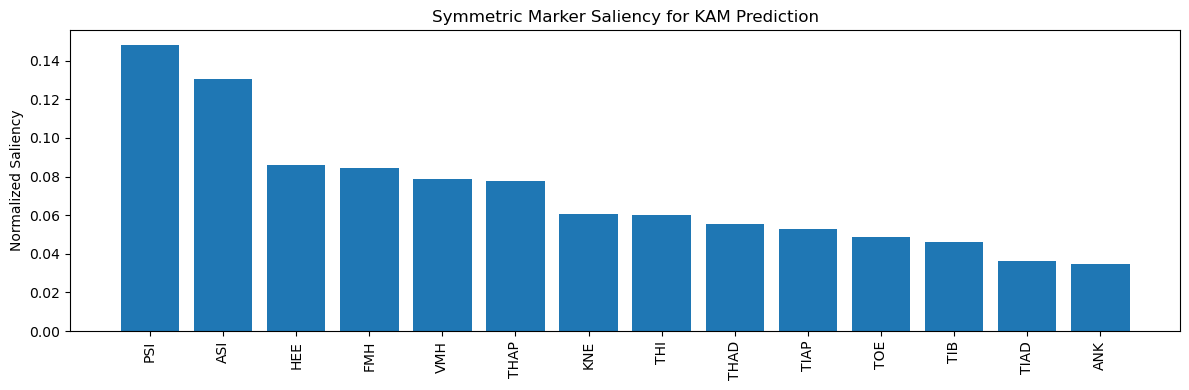

🔍 Top influential symmetric markers:
PSI: 0.1483
ASI: 0.1304
HEE: 0.0859
FMH: 0.0843
VMH: 0.0787
THAP: 0.0775
KNE: 0.0605
THI: 0.0602
THAD: 0.0554
TIAP: 0.0529


In [4]:
# Compute saliency using validation set
merged_saliency = compute_saliency_map_symmetric(model, val_loader, device='cpu')

# Sort markers by saliency score (descending)
import matplotlib.pyplot as plt

sorted_items = sorted(merged_saliency.items(), key=lambda x: -x[1])
labels, values = zip(*sorted_items)

# Plot saliency scores as a bar chart
plt.figure(figsize=(12, 4))
plt.bar(labels, values)
plt.xticks(rotation=90)
plt.ylabel("Normalized Saliency")
plt.title("Symmetric Marker Saliency for KAM Prediction")
plt.tight_layout()
plt.savefig("merged_saliency.png")
plt.show()

# Print the top 10 most influential symmetric markers
print("🔍 Top influential symmetric markers:")
for name, score in sorted_items[:10]:
    print(f"{name}: {score:.4f}")


# marker筛选

In [ ]:
def evaluate_marker_combinations(
    saliency_dict,
    top_k_list,
    root_dir='random_dataset',
    epochs=300,
    patience=30,
    all_marker_result=None,
    final_model_path='best_marker_combination.pth'
):
    """
    Evaluate model performance with different top-k marker subsets selected by saliency.

    Args:
        saliency_dict (dict): Symmetric saliency scores, e.g., {'ANK': 0.12, ...}
        top_k_list (list): List of k values for top-k marker selection, e.g., [4, 6, 11]
        root_dir (str): Path to dataset root folder containing 'train' and 'val'
        epochs (int): Maximum number of training epochs
        patience (int): Early stopping patience
        all_marker_result (float or None): Optional val loss of all-marker model for comparison
        final_model_path (str): Path to save the best-performing model

    Returns:
        results (list): List of tuples (Top-k name, selected suffixes, val loss)
    """
    results = []
    sorted_markers = sorted(saliency_dict.items(), key=lambda x: -x[1])
    best_model_file = None

    for k in top_k_list:
        selected_suffixes = [name for name, _ in sorted_markers[:k]]
        print(f"\n🔁 Training with Top-{k} markers: {selected_suffixes}")

        # Prepare datasets and loaders
        train_set = KAMDataset(os.path.join(root_dir, 'train'), selected_suffixes)
        val_set = KAMDataset(os.path.join(root_dir, 'val'), selected_suffixes)

        train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

        # Train model
        model = PointNetTransformerRegressor()
        model_save_path = f"model_top{k}.pth"
        train_model(model, train_loader, val_loader, epochs=epochs, patience=patience, save_path=model_save_path)
        model.load_state_dict(torch.load(model_save_path))

        # Evaluate on validation set
        model.eval()
        total_val_loss = 0
        total_count = 0
        with torch.no_grad():
            for x, y, m in val_loader:
                pred = model(x, m)
                loss = masked_mse_loss(pred, y, m)
                total_val_loss += loss.item() * x.size(0)
                total_count += x.size(0)

        avg_val_loss = total_val_loss / total_count
        results.append((f"Top-{k}", selected_suffixes, avg_val_loss))
        print(f"✅ Top-{k} markers Val Loss: {avg_val_loss:.6f}")

        # Track best model path
        if best_model_file is None or avg_val_loss < min([r[2] for r in results[:-1]]):
            best_model_file = model_save_path

    # Add all-marker baseline result (if provided)
    if all_marker_result is not None:
        results.append(("All", "All markers", all_marker_result))
        print(f"\n✅ Included all markers baseline Val Loss: {all_marker_result:.6f}")

    # Report best result
    best = min(results, key=lambda x: x[2])
    print("\n🏆 Best marker combination:")
    print(f"{best[0]} markers: {best[1]}")
    print(f"Val Loss: {best[2]:.6f}")

    # Save best model
    if best_model_file is not None:
        import shutil
        shutil.copyfile(best_model_file, final_model_path)
        print(f"✅ Best model saved to: {final_model_path}")

    return results


In [ ]:
# Evaluate different top-K combinations and save the best as best_marker_combination.pth
top_k_list = [4, 6, 11, 14]
results = evaluate_marker_combinations(
    merged_saliency,
    top_k_list,
    all_marker_result=None,
    final_model_path='best_marker_combination.pth'
)



🔁 正在训练 Top-4 markers: ['PSI', 'ASI', 'HEE', 'FMH']
✅ 加载了 2336 个样本（使用 4 个 marker）
✅ 加载了 292 个样本（使用 4 个 marker）
Epoch 1, Train Loss: 2.7056, Val Loss: 2.2504
✅ Top-4 markers Val Loss: 2.309776

🔁 正在训练 Top-6 markers: ['PSI', 'ASI', 'HEE', 'FMH', 'VMH', 'KNE']
✅ 加载了 2336 个样本（使用 6 个 marker）
✅ 加载了 292 个样本（使用 6 个 marker）
Epoch 1, Train Loss: 2.8194, Val Loss: 2.4052
✅ Top-6 markers Val Loss: 2.438521

🔁 正在训练 Top-11 markers: ['PSI', 'ASI', 'HEE', 'FMH', 'VMH', 'KNE', 'THI', 'THAP', 'THAD', 'TOE', 'TIAP']
✅ 加载了 2336 个样本（使用 11 个 marker）
✅ 加载了 292 个样本（使用 11 个 marker）
Epoch 1, Train Loss: 2.6571, Val Loss: 2.9223
✅ Top-11 markers Val Loss: 2.948921

🔁 正在训练 Top-13 markers: ['PSI', 'ASI', 'HEE', 'FMH', 'VMH', 'KNE', 'THI', 'THAP', 'THAD', 'TOE', 'TIAP', 'TIB', 'ANK']
✅ 加载了 2336 个样本（使用 13 个 marker）
✅ 加载了 292 个样本（使用 13 个 marker）
Epoch 1, Train Loss: 2.6480, Val Loss: 1.8793
✅ Top-13 markers Val Loss: 1.926917

🏆 最佳组合:
Top-13 markers: ['PSI', 'ASI', 'HEE', 'FMH', 'VMH', 'KNE', 'THI', 'THAP', 'THAD', '

# 参数调优

# 模型评估

In [ ]:
evaluate_model(model, test_loader)
print("✅ 训练和测试可视化完成")

In [ ]:
def plot_prediction_vs_ground_truth(model, dataset, sample_idx=0, device='cpu', save_path=None, show=True):
    model.eval()

    sample = dataset[sample_idx]
    x = sample['input'].unsqueeze(0).to(device)  # (1, T, N, D)
    y = sample['target'].unsqueeze(0).to(device)  # (1, T)
    T = x.shape[1]
    mask = torch.ones((1, T), dtype=torch.bool).to(device)  # (1, T)

    with torch.no_grad():
        pred = model(x, mask)  # (1, T)

    true_kam = y.squeeze(0).cpu().numpy()
    pred_kam = pred.squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 5))
    plt.plot(true_kam, label='Ground Truth', linewidth=2)
    plt.plot(pred_kam, label='Prediction', linestyle='--')
    plt.xlabel('Frame')
    plt.ylabel('KAM')
    plt.title(f'Sample {sample_idx} - KAM Prediction vs Ground Truth')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        plt.close()
    elif show:
        plt.show()


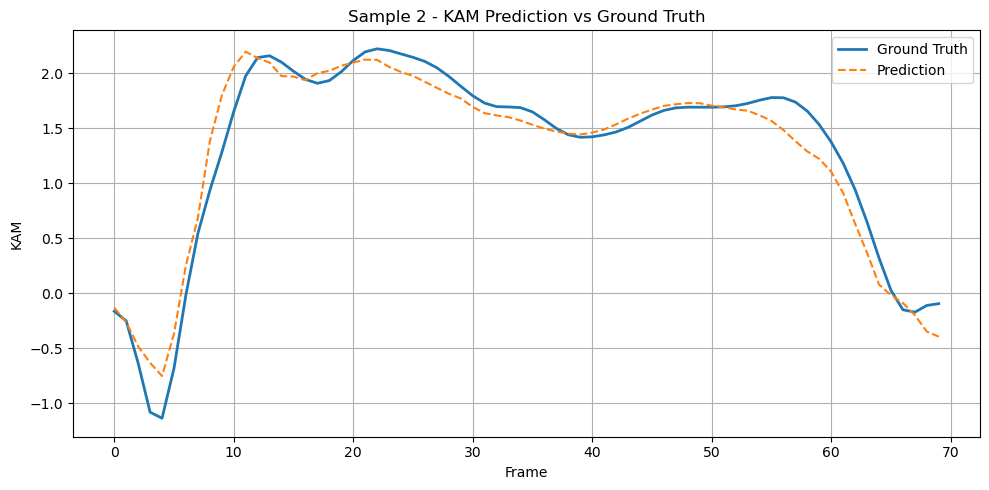

In [ ]:
# ✅ 如果你想可视化 sample 0 的预测结果（显示图像）
plot_prediction_vs_ground_truth(model, test_set, sample_idx=2)


In [ ]:
def extract_peak_kam_metrics(model, dataset, save_csv_path='results/peak_kam_summary.csv', device='cpu'):
    model.eval()
    records = []

    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)      # (1, T, N, D)
        y = sample['target'].unsqueeze(0).to(device)     # (1, T)
        T = x.shape[1]
        mask = torch.ones((1, T), dtype=torch.bool).to(device)
        filename = sample['filename']

        with torch.no_grad():
            pred = model(x, mask)  # (1, T)

        pred_kam = pred.squeeze(0).cpu().numpy()
        true_kam = y.squeeze(0).cpu().numpy()

        mid = T // 2
        true_kam1 = np.max(true_kam[:mid]) if mid > 0 else np.nan
        true_kam2 = np.max(true_kam[mid:]) if mid < T else np.nan
        pred_kam1 = np.max(pred_kam[:mid]) if mid > 0 else np.nan
        pred_kam2 = np.max(pred_kam[mid:]) if mid < T else np.nan

        records.append({
            'n': filename,
            'peak KAM1 Actual': true_kam1,
            'peak KAM1 Predict': pred_kam1,
            'peak KAM2 Actual': true_kam2,
            'peak KAM2 Predict': pred_kam2,
        })

    df = pd.DataFrame(records)
    df.to_csv(save_csv_path, index=False)
    print(f"✅ 峰值KAM统计已保存至: {save_csv_path}")
    return df


In [ ]:
from numpy import mean, std

df = extract_peak_kam_metrics(model, test_set, save_csv_path='results/peak_kam_summary3.0.csv', device='cpu')


kam1_mse = mean((df['peak KAM1 Actual'] - df['peak KAM1 Predict'])**2)
kam2_mse = mean((df['peak KAM2 Actual'] - df['peak KAM2 Predict'])**2)

print("📊 外部单独统计结果：")
print(f"Peak KAM1 MSE  → Mean = {kam1_mse:.6f}")
print(f"Peak KAM2 MSE  → Mean = {kam2_mse:.6f}")

✅ 峰值KAM统计已保存至: results/peak_kam_summary1.0.csv
📊 外部单独统计结果：
Peak KAM1 MSE  → Mean = 0.516518
Peak KAM2 MSE  → Mean = 0.455495


In [ ]:
def export_kam_curves_to_csv(model, dataset, device='cpu',
                             pred_csv='results/pred_kam_curves3.0.csv',
                             gt_csv='results/gt_kam_curves3.0.csv'):
    model.eval()
    all_pred_curves = []
    all_gt_curves = []
    filenames = []

    max_len = 0  # 用于统一帧数长度（pad用）

    # 遍历所有测试样本
    for idx in range(len(dataset)):
        sample = dataset[idx]
        x = sample['input'].unsqueeze(0).to(device)  # (1, T, N, D)
        y = sample['target'].unsqueeze(0).to(device)  # (1, T)
        T = x.shape[1]
        mask = torch.ones((1, T), dtype=torch.bool).to(device)
        filename = sample['filename']

        with torch.no_grad():
            pred = model(x, mask)  # (1, T)

        pred_kam = pred.squeeze(0).cpu().numpy()
        true_kam = y.squeeze(0).cpu().numpy()

        all_pred_curves.append(pred_kam)
        all_gt_curves.append(true_kam)
        filenames.append(filename)
        max_len = max(max_len, T)

    # 填充每个曲线为相同长度
    def pad_to_max(arr_list):
        return np.array([
            np.pad(arr, (0, max_len - len(arr)), 'constant', constant_values=np.nan)
            for arr in arr_list
        ]).T  # 转置：行是帧，列是样本

    pred_matrix = pad_to_max(all_pred_curves)
    gt_matrix = pad_to_max(all_gt_curves)

    pred_df = pd.DataFrame(pred_matrix, columns=filenames)
    gt_df = pd.DataFrame(gt_matrix, columns=filenames)

    os.makedirs(os.path.dirname(pred_csv), exist_ok=True)
    pred_df.to_csv(pred_csv, index=False)
    gt_df.to_csv(gt_csv, index=False)

    print(f"✅ 已导出预测值 CSV 到：{pred_csv}")
    print(f"✅ 已导出真实值 CSV 到：{gt_csv}")


In [ ]:
export_kam_curves_to_csv(model, test_set)


✅ 已导出预测值 CSV 到：results/pred_kam_curves1.0.csv
✅ 已导出真实值 CSV 到：results/gt_kam_curves1.0.csv
